In [1]:
import math

import matplotlib.pyplot as plt
import pandas as pd
import optuna
import time
import json
import numpy as np
import sys

sys.path.append("da_mine")

import example_parameters
from model import *
from parameters import Parameters
from da_utils import Visualization

plt.rcParams['figure.figsize'] = [12, 8]


In [2]:
def normalize_array(array):
    max_ = max(array)
    if max_ == 0:
        return array
    return [x / max_ for x in array]


def compute_for_visualization(parameters, simulation_len, epsilon, normalize=True, step_fun=step):
    xc, xe, y, w, am, aM, bc, be, s, gamma, lambda_, kappa, delta, rho = parameters.unpacked()

    xcs, xes, ys, ws = [xc], [xe], [y], [w]

    for i in range(int(simulation_len / epsilon)):
        xc, xe, y, w = step_fun(xc, xe, y, w, am, aM, bc, be, s, gamma, lambda_, kappa, delta, rho, epsilon)
        xcs.append(xc)
        xes.append(xe)
        ys.append(y)
        ws.append(w)

    return xcs, xes, ys, ws


def plot(xcs, xes, ys, ws):
    plt.plot(xcs, label="Common people")
    plt.plot(xes, label="Elite population")
    plt.plot(ys, label="Nature")
    plt.plot(ws, label="Accumulated wealth")
    plt.legend()
    plt.show()

11187.969667447607 2082.477034548391 1.4143263769761627 12.902115437300195
11960.363239070502 13246.751149268224 100 145.53393319195158


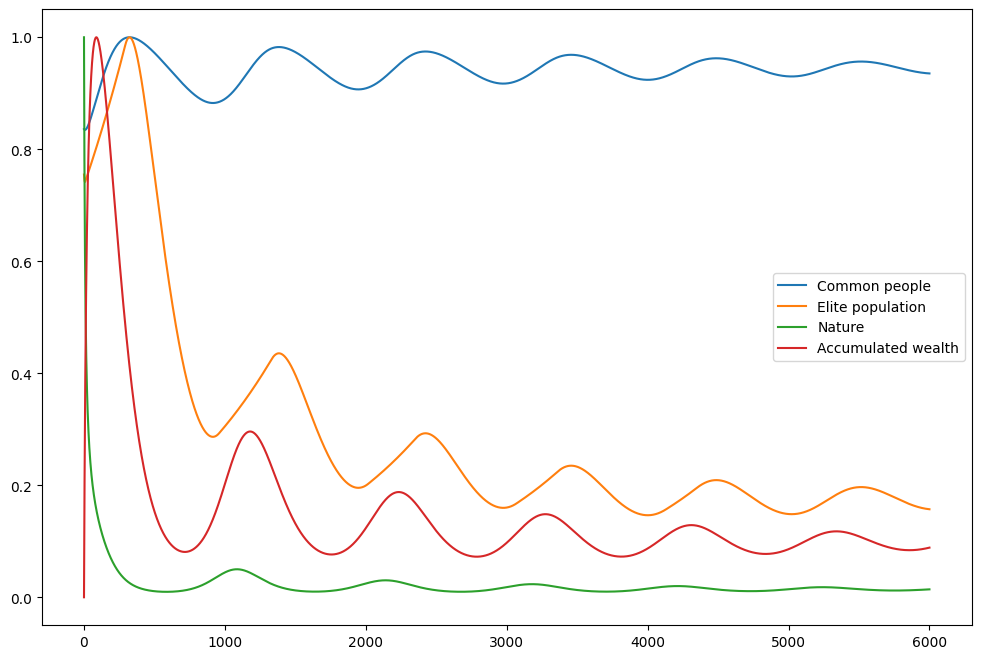

In [3]:
params = example_parameters.elite_equilibrium
simulation_len = params.simulation_len
epsilon = params.epsilon

xcs, xes, ys, ws = compute_for_visualization(params, simulation_len, epsilon)
print(xcs[-1], xes[-1], ys[-1], ws[-1])
print(max(xcs), max(xes), max(ys), max(ws))

normalize = True
if normalize:
    xcsn = normalize_array(xcs)
    xesn = normalize_array(xes)
    ysn = normalize_array(ys)
    wsn = normalize_array(ws)

# plot(xcs, xes, ys, ws)
plot(xcsn, xesn, ysn, wsn)

In [4]:
print([x[0] for x in (xcs, xes, ys, ws)])
print([x[1] for x in (xcs, xes, ys, ws)])
print([x[2] for x in (xcs, xes, ys, ws)])


[10000, 10000, 100, 0]
[9995.0, 9950.0, 91.28, 8.720000000000002]
[9990.957682245764, 9909.758817754235, 84.120325408, 16.588436192000003]


In [5]:
def _elite_equilibrium2():
    # metaparameters
    # oscylacja do stałej
    simulation_len = 600
    epsilon = .1

    # constants
    am, aM = 0.01, 0.06  # normal and famine death rates
    bc, be = 0.06, 0.016  # commoner and elite birth rate
    s, rho = 6e-4, 6e-3  # Subsistence salary per capita, Threshold wealth per capita
    gamma, lambda_ = 0.011, 110  # nature regeneration rate, nature carrying capacity
    kappa, delta = 11, 8e-5  # inequality factor, depletion(production) factor

    # variables
    xc, xe, y, w = 10000, 10000, lambda_, 0  # commoner pop, elite pop, nature, accumulated wealth

    return Parameters(simulation_len, epsilon, am, aM, bc, be, s, rho, gamma, lambda_, kappa, delta, xc, xe, y, w)


elite_equilibrium2 = _elite_equilibrium2()
elite_equilibrium3 = example_parameters._elite_equilibrium()

11610.797922322514 0.03408934607907049 0.9918009618417364 0.1736074576912009
13646.272494084134 10150.9018913624 100 16.29750683214825


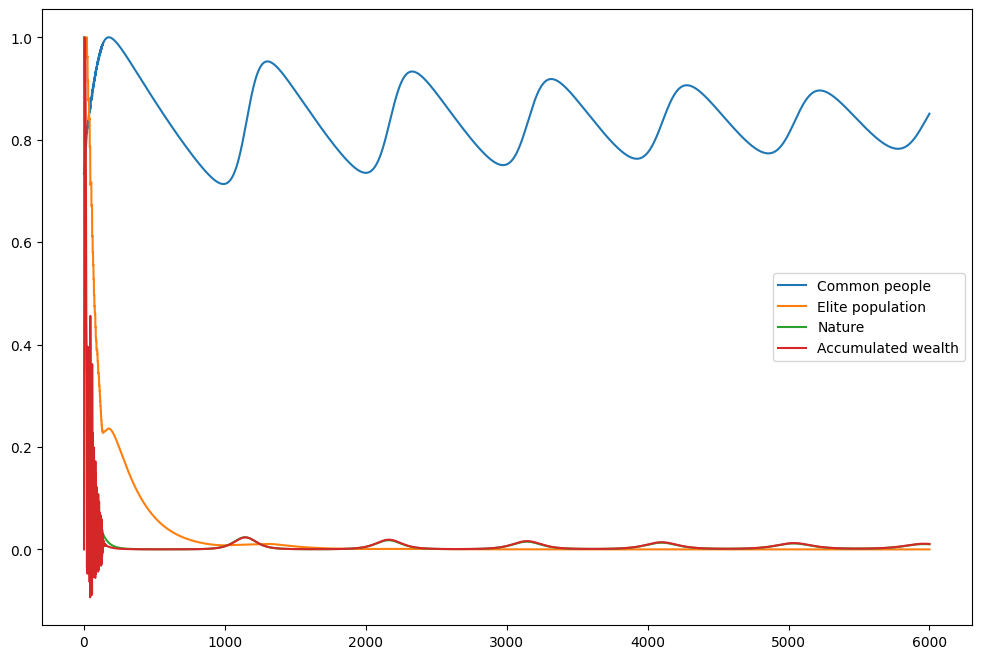

In [6]:
params = elite_equilibrium3
simulation_len = params.simulation_len
epsilon = params.epsilon

xcs, xes, ys, ws = compute_for_visualization(params, simulation_len, epsilon, step_fun=step2)
print(xcs[-1], xes[-1], ys[-1], ws[-1])
print(max(xcs), max(xes), max(ys), max(ws))

normalize = True
# normalize = False
if normalize:
    xcs = normalize_array(xcs)
    xes = normalize_array(xes)
    ys = normalize_array(ys)
    ws = normalize_array(ws)

plot(xcs, xes, ys, ws)

In [7]:
class HandyModel:
    def __init__(self, xc, xe, y, w, noise, params, array=None):
        # self.params = params
        self.noise = noise
        self.simulation_len = params.simulation_len
        self.epsilon = params.epsilon

        _, _, _, _, self.am, self.aM, self.bc, self.be, self.s, self.gamma, self.lambda_, self.kappa, self.delta, self.rho = params.unpacked()
        self.xc, self.xe, self.y, self.w = xc, xe, y, w

        self.step = step

        if array is not None:
            _, _, _, _, self.am, self.aM, self.bc, self.be, self.s, self.gamma, self.lambda_, self.kappa, self.delta, self.rho = array.tolist()

    def time_integration(self):
        self.xc, self.xe, self.y, self.w = self.step(self.xc, self.xe, self.y, self.w, self.am, self.aM, self.bc, self.be, self.s, self.gamma, self.lambda_, self.kappa, self.delta,
                                                     self.rho, self.epsilon)

        return self.xc, self.xe, self.y, self.w

    def time_integration_full(self):
        self.xc, self.xe, self.y, self.w = self.step(self.xc, self.xe, self.y, self.w, self.am, self.aM, self.bc, self.be, self.s, self.gamma, self.lambda_, self.kappa, self.delta,
                                                     self.rho, self.epsilon)

        return self.xc, self.xe, self.y, self.w, self.am, self.aM, self.bc, self.be, self.s, self.gamma, self.lambda_, self.kappa, self.delta, self.rho

    def observation_noise(self):
        self.xc = self.xc + np.random.normal(0, self.noise)
        self.xe = self.xe  #+ np.random.normal(0,self.noise)
        self.y = self.y  #+ np.random.normal(0,self.noise)
        self.w = self.w  #+ np.random.normal(0,self.noise)

        return self.xc, self.xe, self.y, self.w


class HandyModel2(HandyModel):
    def __init__(self, xc, xe, y, w, noise, params, array=None):
        super().__init__(xc, xe, y, w, noise, params, array)  #time step
        self.step = step2



In [8]:
#time step
length = 6000

#Observation noise
noise = 150  #standard deviation

#Initial condition
xct = example_parameters.elite_equilibrium.xc
xet = example_parameters.elite_equilibrium.xe
yt = example_parameters.elite_equilibrium.y
wt = example_parameters.elite_equilibrium.w  # #True

# xcsf = elite_equilibrium2.xc
# xesf = elite_equilibrium2.xe
# ysf = elite_equilibrium2.y
# wsf = elite_equilibrium2.w  #Simulation
xcsf = elite_equilibrium3.xc
xesf = elite_equilibrium3.xe
ysf = elite_equilibrium3.y
wsf = elite_equilibrium3.w  #Simulation

#For Visuallization
xctrue, xetrue, ytrue, wtrue = [xct], [xet], [yt], [wt]  #True for visualization
xcobs, xeobs, yobs, wobs = [xct], [xet], [yt], [wt]  #Observation for visualization
xcsim, xesim, ysim, wsim = [xcsf], [xesf], [ysf], [wsf]  #Simulation for visualization

xcs, xes, ys, ws = xcsf, xesf, ysf, wsf

for t in range(length):
    #True,Observation and Simulation
    model = HandyModel(xct, xet, yt, wt, noise, example_parameters.elite_equilibrium)
    xct, xet, yt, wt = model.time_integration()
    xco, xeo, yo, wo = model.observation_noise()

    #Simulation
    # model = HandyModel(xcs, xes, ys, ws, noise, elite_equilibrium2)
    model = HandyModel2(xcs, xes, ys, ws, noise, elite_equilibrium3)
    xcs, xes, ys, ws = model.time_integration()

    #visualization
    xctrue.append(xct)
    xetrue.append(xet)
    ytrue.append(yt)
    wtrue.append(wt)

    xcobs.append(xco)
    xeobs.append(xeo)
    yobs.append(yo)
    wobs.append(wo)

    xcsim.append(xcs)
    xesim.append(xes)
    ysim.append(ys)
    wsim.append(ws)

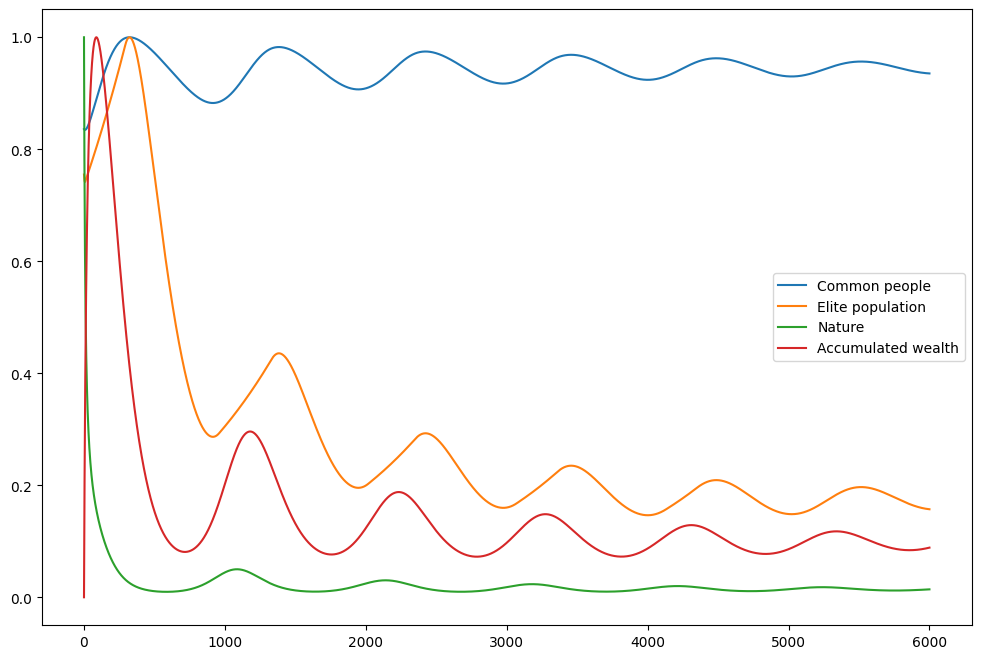

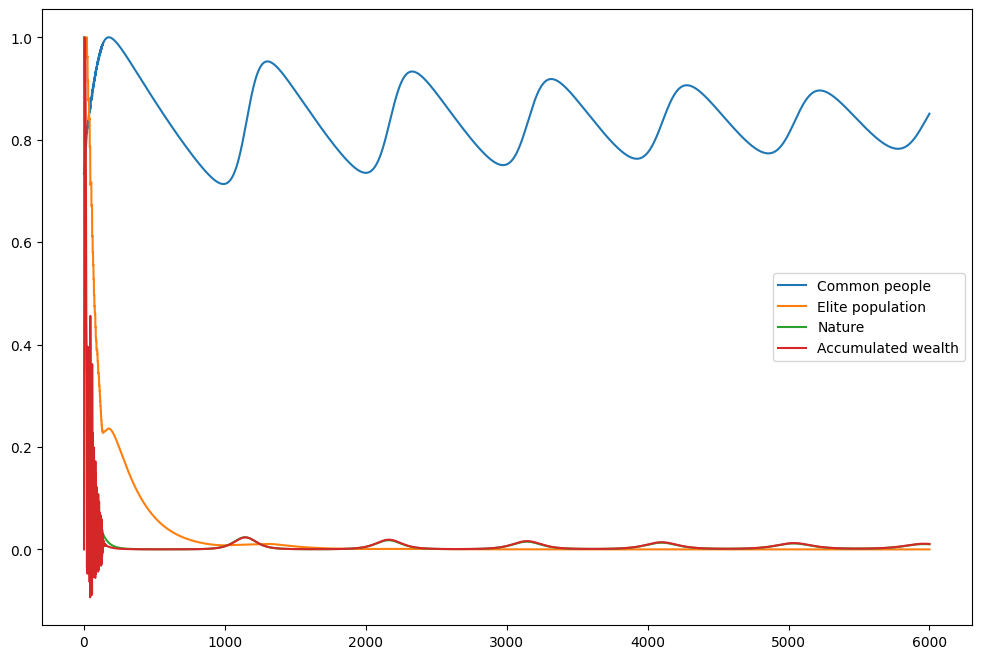

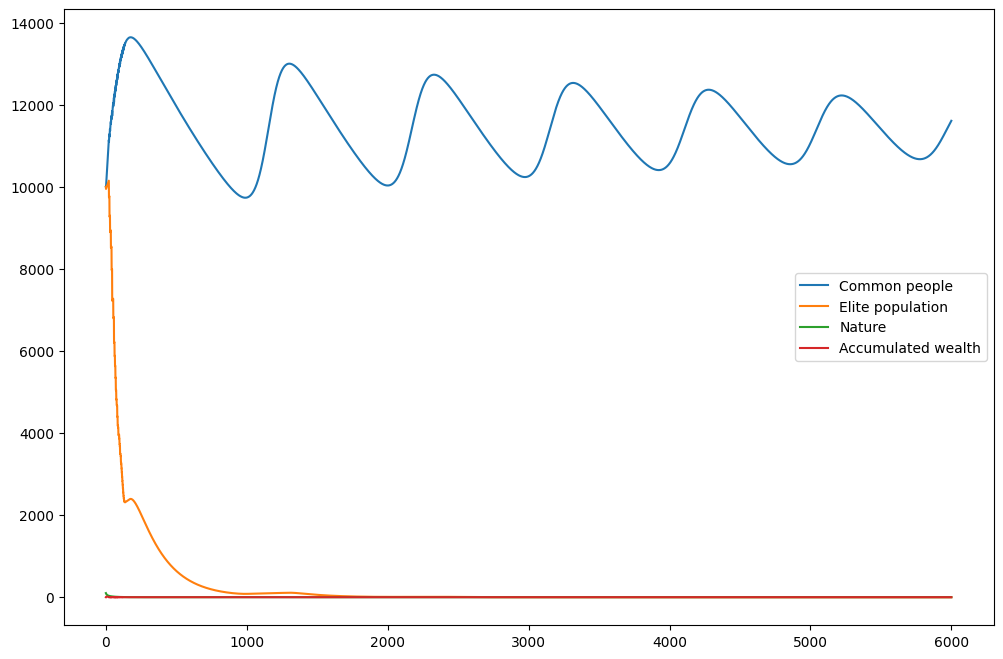

In [9]:
(xcsimn, xesimn, ysimn, wsimn) = [normalize_array(x) for x in (xcsim, xesim, ysim, wsim)]
(xctruen, xetruen, ytruen, wtruen) = [normalize_array(x) for x in (xctrue, xetrue, ytrue, wtrue)]

# plot(xctrue,xetrue,ytrue,wtrue)
# plot(xcobs,xeobs,yobs,wobs)
plot(xctruen, xetruen, ytruen, wtruen)
plot(xcsimn, xesimn, ysimn, wsimn)
plot(xcsim, xesim, ysim, wsim)

In [10]:
def np_1d_zeros_with_single_one(size, pos):
    return np.eye(1, size, k=pos).reshape(-1)


np_1d_zeros_with_single_one(10, 2)

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
def cost(proposed_state: np.ndarray, last_state: np.ndarray, observation: np.ndarray, observation_mask: np.ndarray, f):  #proposed_state  -> x,  last_state -> xb
    first = proposed_state - last_state
    second = (observation - f(proposed_state)) * observation_mask
    # return np.matmul(first.T, first) * 0.5 + np.matmul(second.T * second) * 0.5
    return np.dot(first, first) * 0.5 + np.dot(second, second) * 0.5


# only for (x - x_b)
def diff_vector_1(proposed_state, last_state):
    return 2 * (proposed_state - last_state)


diff_epsilon = 0.001


# only for (y_0 - H(x))
def diff_vector_2(proposed_state: np.ndarray, observation: np.ndarray, observation_mask: np.ndarray, f):
    H = f(proposed_state)
    deriv = np.zeros(proposed_state.shape)

    for i in range(len(observation_mask)):
        single_mask = np_1d_zeros_with_single_one(len(observation_mask), i)
        proposed_state_with_delta = proposed_state + (single_mask * diff_epsilon)
        H1 = f(proposed_state_with_delta)
        deriv += (H1 - H) * single_mask / diff_epsilon

    return 2 * deriv * (H - observation)


def diff_combined(proposed_state: np.ndarray, last_state: np.ndarray, observation: np.ndarray, observation_mask: np.ndarray, f, measurement_weight=0.5):
    # return (diff_vector_1(proposed_state, last_state) + diff_vector_2(proposed_state, observation, observation_mask, f)) * 0.5
    return (diff_vector_1(proposed_state, last_state) * (1 - measurement_weight) + diff_vector_2(proposed_state, observation, observation_mask, f) * measurement_weight) * 0.5


def simulate_step_with_model(state, model_class):
    if len(state) == 4:
        model = HandyModel(float(state[0]), float(state[1]), float(state[2]), float(state[3]), noise, example_parameters.elite_equilibrium)
        return np.array(model.time_integration())

    model = model_class(float(state[0]), float(state[1]), float(state[2]), float(state[3]), noise, elite_equilibrium2, state)
    # model = HandyModel(float(state[0]), float(state[1]), float(state[2]), float(state[3]), noise, example_parameters.elite_equilibrium, state)
    return np.array(model.time_integration_full())

In [12]:
cost(np.array([2, 2, 2]), np.array([1, 1, 1]), np.array([3, 3, 3]), np.array([1, 1, 1]), lambda x: x + 1)

1.5

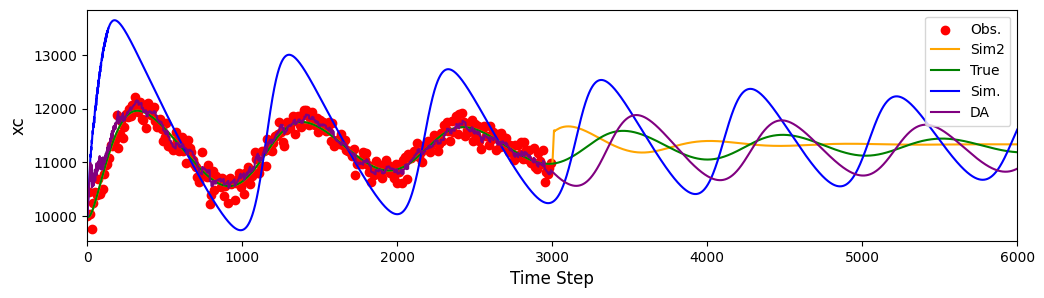

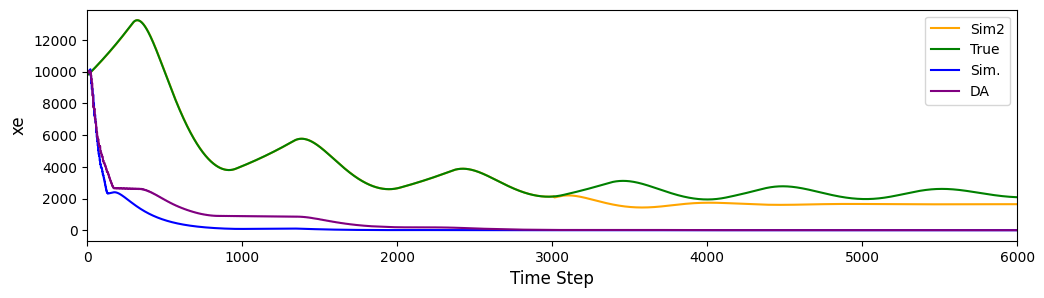

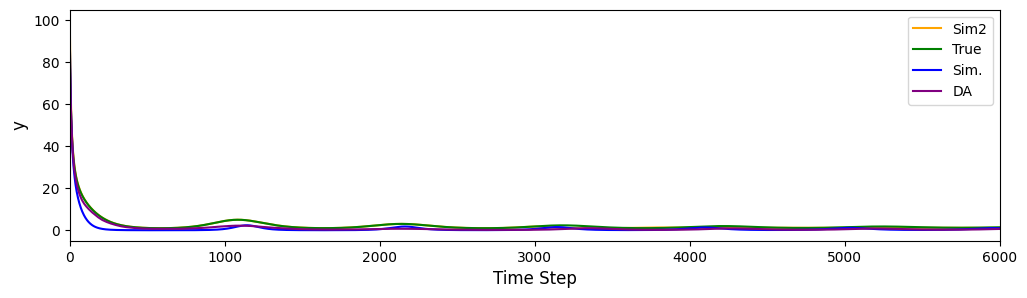

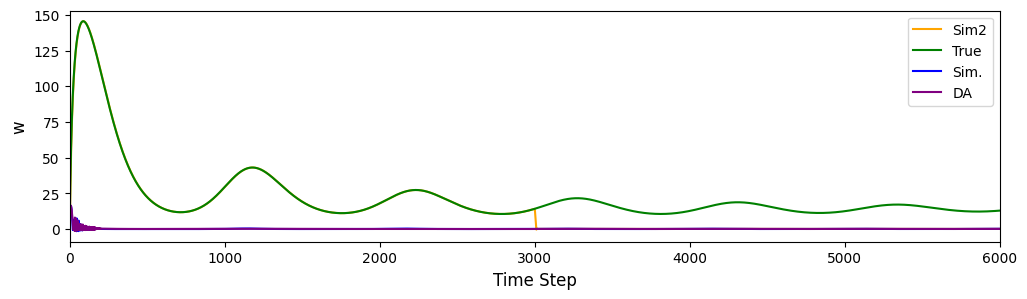

In [13]:
def train(params2, obs_interval=100, nens=100, initial_noise=4.0, ratio=0.5, math_mode=False):
    nt_asm = int(length * ratio)

    xcda, xeda, yda, wda = [xcsf], [xesf], [ysf], [wsf]

    xcs, xes, ys, ws = xcsf, xesf, ysf, wsf  #simulation
    xcsim2, xesim2, ysim2, wsim2 = [xcs], [xes], [ys], [ws]

    state = np.array(params2.unpacked())

    for t in range(length):
        if np.mod(t, obs_interval) == 0 and nt_asm > t > 0:
            observation = np.array([xcobs[t], xeobs[t], yobs[t], wobs[t], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
            observation_mask = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
            variable_mask = np.array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
            obs = observation * observation_mask
            proposed_state = state.copy()

            for _ in range(20):
                proposed_state -= diff_combined(proposed_state, state, obs, observation_mask, lambda s: simulate_step_with_model(s, HandyModel2), measurement_weight=0.5) * observation_mask * 0.05
                proposed_state -= diff_combined(proposed_state, state, obs, observation_mask, lambda s: simulate_step_with_model(s, HandyModel2), measurement_weight=0.5) * variable_mask * 0.001
                proposed_state -= diff_combined(proposed_state, state, obs, observation_mask, lambda s: simulate_step_with_model(s, HandyModel2), measurement_weight=0.5) * 0.000005
            state = proposed_state

        else:
            state = simulate_step_with_model(state, HandyModel2)
            pass

        xcda.append(state[0])
        xeda.append(state[1])
        yda.append(state[2])
        wda.append(state[3])

        if t == nt_asm:  # start new simulation
            xcsf2, xesf2, ysf2, wsf2 = xctrue[t], xetrue[t], ytrue[t], wtrue[t]
        if t > nt_asm:  #second simulaion:
            model = HandyModel2(xcsf2, xesf2, ysf2, wsf2, noise, params2)
            xcsf2, xesf2, ysf2, wsf2 = model.time_integration()
            xcsim2.append(xcsf2)
            xesim2.append(xesf2)
            ysim2.append(ysf2)
            wsim2.append(wsf2)
        else:
            xcsim2.append(xctrue[t])
            xesim2.append(xetrue[t])
            ysim2.append(ytrue[t])
            wsim2.append(wtrue[t])

    vis = Visualization.Visualization(xcobs, xctrue, xcsim, xcsim2, xcda, obs_interval, nt_asm, 'xc', 6000).fit()
    vis2 = Visualization.Visualization(None, xetrue, xesim, xesim2, xeda, obs_interval, nt_asm, 'xe', 6000).fit()
    vis3 = Visualization.Visualization(None, ytrue, ysim, ysim2, yda, obs_interval, nt_asm, 'y', 6000).fit()
    vis4 = Visualization.Visualization(None, wtrue, wsim, wsim2, wda, obs_interval, nt_asm, 'w', 6000).fit()


train(example_parameters.elite_equilibrium, obs_interval=10)

In [15]:
def normalize_array(array):
    max_ = max(array)
    if max_ == 0:
        return array
    return [x / max_ for x in array]


def measure_noise(series):
    all_delta = 0
    for i in range(len(series) - 1):
        all_delta += abs(series[i + 1] - series[i])
    return all_delta


# simulation_len = 6
# simulation_len = 60
simulation_len = 600
epsilon = .1
steps = int(simulation_len / epsilon)

params = example_parameters._elite_equilibrium()


# computation
def compute(parameters, simulation_len, epsilon):
    xc, xe, y, w, am, aM, bc, be, s, gamma, lambda_, kappa, delta, rho = parameters.unpacked()
    xcs, xes, ys, ws = [xc], [xe], [y], [w]

    for i in range(int(simulation_len / epsilon)):
        xc, xe, y, w = step2(xc, xe, y, w, am, aM, bc, be, s, gamma, lambda_, kappa, delta, rho, epsilon)

        xcs.append(xc)
        xes.append(xe)
        ys.append(y)
        ws.append(w)

    return xcs, xes, ys, ws


def objective(trial: optuna.Trial):
    xc, xe, y, w, am, aM, bc, be, s, gamma, lambda_, kappa, delta, rho = params.unpacked()

    diff = 10.1

    am = trial.suggest_float("am", params.am / diff, params.am * diff)
    aM = trial.suggest_float("aM", params.aM / diff, params.aM * diff)
    bc = trial.suggest_float("bc", params.bc / diff, params.bc * diff)
    be = trial.suggest_float("be", params.be / diff, params.be * diff)
    s = trial.suggest_float("s", params.s / diff, params.s * diff)
    rho = trial.suggest_float("rho", params.rho / diff, params.rho * diff)
    gamma = trial.suggest_float("gamma", params.gamma / diff, params.gamma * diff)
    lambda_ = trial.suggest_float("lambda_", params.lambda_ / diff, params.lambda_ * diff)
    kappa = trial.suggest_float("kappa", 1, 100)
    delta = trial.suggest_float("delta", params.delta / diff, params.delta * diff)

    xcs, xes, ys, ws = compute(Parameters(simulation_len, 0.1, am, aM, bc, be, s, rho, gamma, lambda_, kappa, delta, xc, xe, y, w), simulation_len, 0.1)

    (xcsn, xesn, ysn, wsn) = [normalize_array(x) for x in (xcs, xes, ys, ws)]

    err = 0
    flag = True
    completed_vars = 0
    all_noise = 0
    for sim2, sim1, exp_size in zip([xcsn, xesn, ysn, wsn], [xctruen, xetruen, ytruen, wtruen], [10000, 10000, 100, 100]):
        print(sim2[0], sim1[0])
        for i in range(len(xcs)):
            x = (sim2[i] - sim1[i]) / exp_size
            x = x * x
            # x = abs(x)
            # if x == math.nan:
            if str(x) == 'nan':
                flag = False
                break
            if abs(sim2[i] - exp_size) / exp_size > 100:
                flag = False
                break
            err += x
        if not flag:
            break
        completed_vars += 1
        all_noise += abs(measure_noise(sim2) - measure_noise(sim1))

    if len(xcs) < steps:
        err += (steps - len(xcs)) * 1e6

    err += (4 - completed_vars) * 1e8

    # print(f"Error: {err}")
    print(f"Error: {err} Noise {all_noise}")

    return err + all_noise / 1000


study = optuna.create_study(directions=["minimize"])
# study = optuna.create_study(directions=["minimize"], sampler=optuna.samplers.RandomSampler())
# study = optuna.create_study(directions=["minimize"], sampler=optuna.samplers., pruner=optuna.pruners.HyperbandPruner())
start = time.time()
# study.optimize(objective, n_trials=200, timeout=30, show_progress_bar=True)
study.optimize(objective, n_trials=500, timeout=40, show_progress_bar=True)
# study.optimize(objective, n_trials=2000, timeout=40, show_progress_bar=True)
# study.optimize(objective, n_trials=20000, timeout=300, show_progress_bar=True)

print(f"Finished in {time.time() - start}")
print("Number of finished trials: ", len(study.trials))


[I 2023-01-08 21:27:57,798] A new study created in memory with name: no-name-dde373c2-7230-4c19-9120-f70ed8062880
C:\Users\Pawel\Documents\AGH\ISZ\Complex-systems\venv\Lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/500 [00:00<?, ?it/s]

0.9220979391040769 0.8360950081627411
Error: 400100431.51382905 Noise 0
[I 2023-01-08 21:27:57,910] Trial 0 finished with value: 400100431.51382905 and parameters: {'am': 0.005712623454135161, 'aM': 0.18908226186259075, 'bc': 0.5116547886692807, 'be': 0.16941992551823074, 's': 0.0037800074844870917, 'rho': 0.01423682090648621, 'gamma': 0.005628492866609875, 'lambda_': 332.777545619579, 'kappa': 66.20122175480643, 'delta': 0.00012171587423920647}. Best is trial 0 with value: 400100431.51382905.
6.64557652483e-142 0.8360950081627411
Error: 400000000.0000016 Noise 0
[I 2023-01-08 21:27:57,923] Trial 1 finished with value: 400000000.0000016 and parameters: {'am': 0.05082353346220855, 'aM': 0.2766838010016123, 'bc': 0.27982659100200447, 'be': 0.0682572531282615, 's': 0.0006336332351171378, 'rho': 0.04641490004286636, 'gamma': 0.03710522180187877, 'lambda_': 104.5658863933233, 'kappa': 80.63051766922541, 'delta': 0.0002002771531118741}. Best is trial 1 with value: 400000000.0000016.
0.930917

In [19]:
# with open("best.json", "w") as outfile:
#     outfile.write(json.dumps(study.best_params))

# best_study = None
# with open("best.json", "r") as file:
#     best_study = json.loads(file.read())

In [20]:
best_study = study.best_params
computed_params = Parameters(simulation_len, 0.1,
                             best_study["am"],
                             best_study["aM"],
                             best_study["bc"],
                             best_study["be"],
                             best_study["s"],
                             best_study["rho"],
                             best_study["gamma"],
                             best_study["lambda_"],
                             best_study["kappa"],
                             best_study["delta"],
                             params.xc,
                             params.xe,
                             params.y,
                             params.w,
                             )
best_study

{'am': 0.0009900990099009901,
 'aM': 0.006930693069306932,
 'bc': 0.006435643564356436,
 'be': 0.0019801980198019802,
 's': 4.950495049504951e-05,
 'rho': 0.0004950495049504951,
 'gamma': 0.0009900990099009901,
 'lambda_': 9.900990099009901,
 'kappa': 1.0,
 'delta': 8.633663366336634e-06}

In [21]:
def visualize(length, new_params, base_params=example_parameters.elite_equilibrium):
    #Observation noise
    noise = 150  #standard deviation

    #Initial condition
    xct = base_params.xc
    xet = base_params.xe
    yt = base_params.y
    wt = base_params.w  # #True

    xcsf = new_params.xc
    xesf = new_params.xe
    ysf = new_params.y
    wsf = new_params.w  #Simulation

    #For Visuallization
    xctrue, xetrue, ytrue, wtrue = [xct], [xet], [yt], [wt]  #True for visualization
    xcsim, xesim, ysim, wsim = [xcsf], [xesf], [ysf], [wsf]  #Simulation for visualization

    xcs, xes, ys, ws = xcsf, xesf, ysf, wsf

    for t in range(length):
        #True,Observation and Simulation
        model = HandyModel(xct, xet, yt, wt, noise, base_params)
        xct, xet, yt, wt = model.time_integration()

        #Simulation
        # model = HandyModel(xcs, xes, ys, ws, noise, elite_equilibrium2)
        model2 = HandyModel2(xcs, xes, ys, ws, noise, new_params)
        xcs, xes, ys, ws = model2.time_integration()

        #visualization
        xctrue.append(xct)
        xetrue.append(xet)
        ytrue.append(yt)
        wtrue.append(wt)

        xcsim.append(xcs)
        xesim.append(xes)
        ysim.append(ys)
        wsim.append(ws)

    (xcsimn, xesimn, ysimn, wsimn) = [normalize_array(x) for x in (xcsim, xesim, ysim, wsim)]
    (xctruen, xetruen, ytruen, wtruen) = [normalize_array(x) for x in (xctrue, xetrue, ytrue, wtrue)]

    print(measure_noise(wtruen))
    print(measure_noise(wsimn))

    plot(xctruen, xetruen, ytruen, wtruen)
    plot(xcsimn, xesimn, ysimn, wsimn)

2.91861021320785
1.9999999999999907


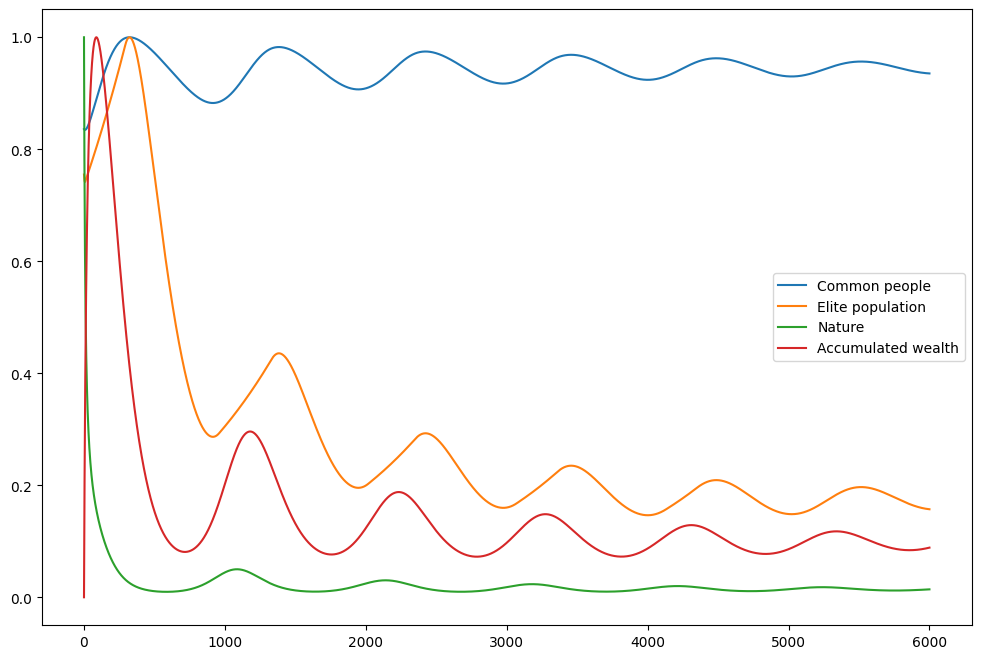

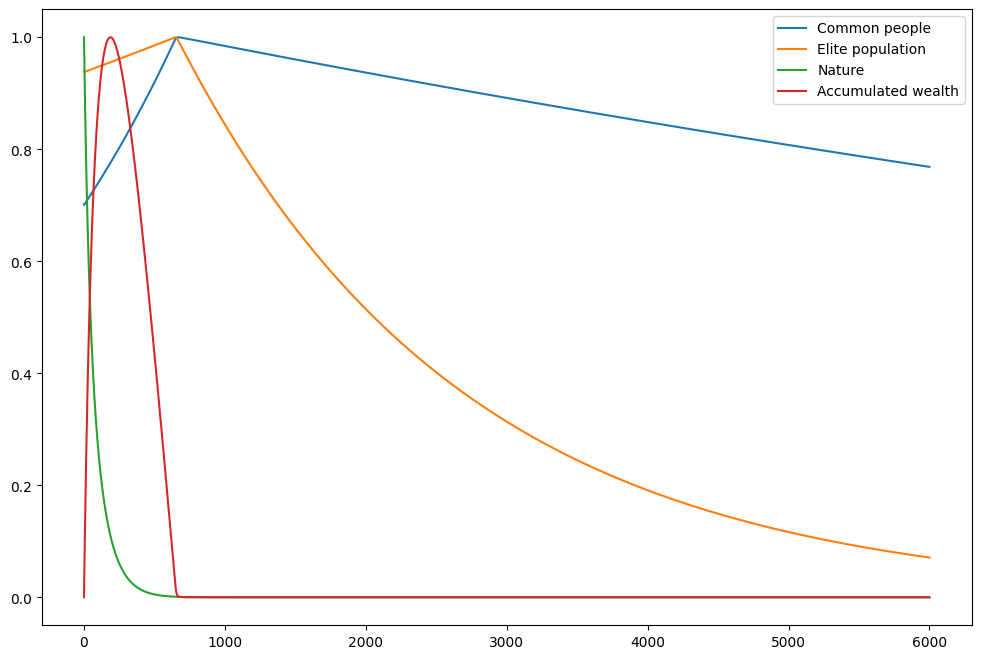

In [22]:
# visualize(60, computed_params)
visualize(6000, computed_params)

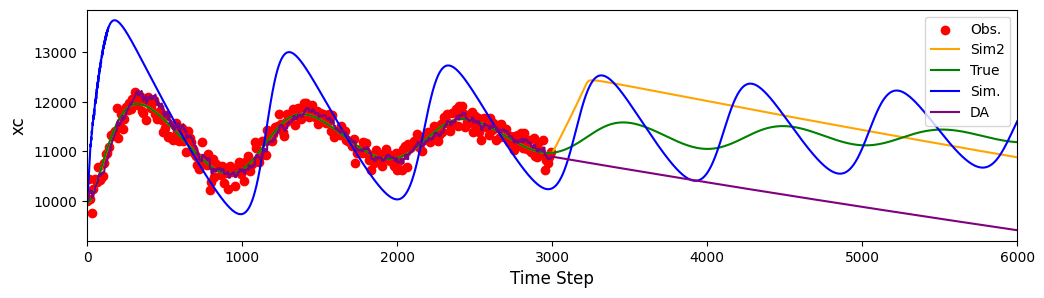

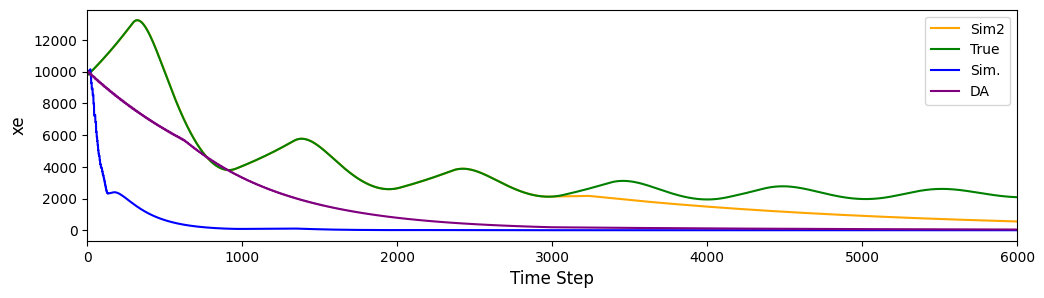

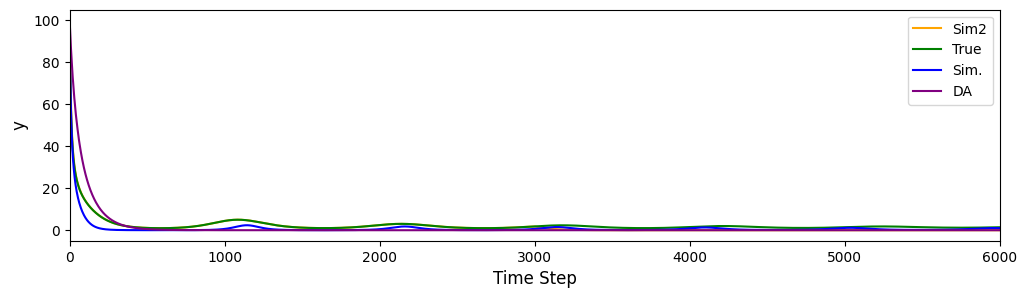

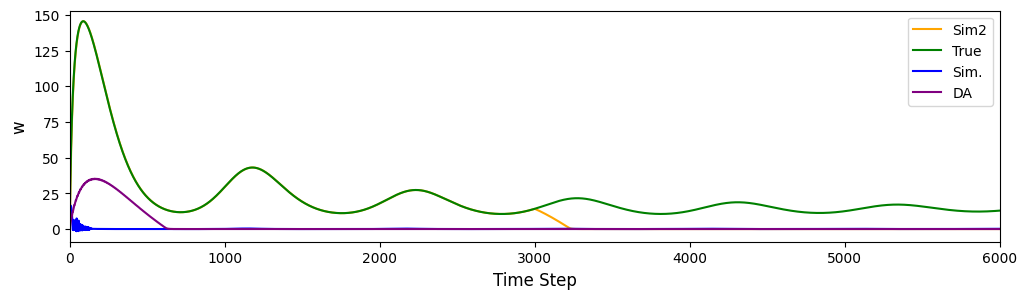

In [23]:
train(computed_params, obs_interval=10)